# Load Dataset

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.models import Sequential

2024-11-19 14:01:01.557999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
# The actual len of dataset is 68 * 32, cuz each batch has 32 ima
len(dataset)

68

(32, 256, 256, 3)
[0 0 0 0 2 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 2 0 0 2 0 2 1 1]


2024-11-19 14:01:14.132837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


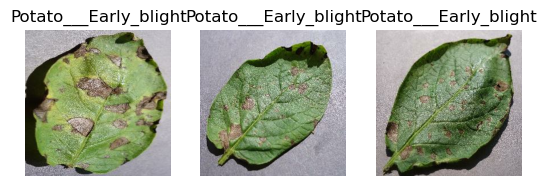

In [11]:
for image_batch, label_batch in dataset.take(1):
    for i in range(3):
        ax = plt.subplot(1,3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
print(image_batch.shape)
print(label_batch.numpy())

# Preprocessing

In [14]:
train_size = 0.8
train_number = len(dataset) * train_size

In [40]:
train_number_int_value = tf.cast(train_number, dtype=tf.int64)
train_ds = dataset.take(train_number_int_value)
len(train_ds)

54

In [42]:
tot_test_ds = dataset.skip(train_number_int_value)
len(tot_test_ds)

14

In [44]:
validation_size = 0.1
validation_number = len(dataset) * validation_size

In [46]:
validation_number_int_value = tf.cast(validation_number, dtype=tf.int64)
validation_ds = tot_test_ds.take(validation_number_int_value)
len(validation_ds)

6

In [48]:
test_ds = tot_test_ds.skip(validation_number_int_value)
len(test_ds)

8

In [50]:
# To bundle the whole split testing and training function
# Seed is like random_state in sklearn
def get_dataset_partitions_tf(ds, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_ds_size = len(ds) * train_split
    validation_ds_size = len(ds) * validation_split

    train_ds = ds.take(int(train_ds_size))
    validation_ds = ds.skip(int(train_ds_size)).take(int(validation_ds_size))
    test_ds = ds.skip(int(train_ds_size)).skip(int(validation_ds_size))
    
    return train_ds, validation_ds, test_ds

In [52]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

In [54]:
len(train_ds)

54

In [56]:
len(validation_ds)

6

In [58]:
len(test_ds)

8

In [74]:
# To optimize the performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [76]:
model = models.Sequential()

In [78]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Resizing and Rescaling
model.add(layers.Resizing(IMAGE_SIZE, IMAGE_SIZE))
model.add(layers.Rescaling(1.0/255))

# Since cnn are not scale or rotation invariant so we need to do data augmentation
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))

#Start to do the cnn
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
# (2, 2) in Pooling means how many row and columns as a group 
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))


model.build(input_shape=input_shape)

In [80]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [82]:
history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = validation_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5395 - loss: 0.9249 - val_accuracy: 0.6927 - val_loss: 0.9038
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8096 - loss: 0.5585 - val_accuracy: 0.8385 - val_loss: 0.4624
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8598 - loss: 0.3507 - val_accuracy: 0.9271 - val_loss: 0.2790
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9276 - loss: 0.1901 - val_accuracy: 0.9427 - val_loss: 0.2215
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9270 - loss: 0.2011 - val_accuracy: 0.9688 - val_loss: 0.1228
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9593 - loss: 0.1204 - val_accuracy: 0.9635 - val_loss: 0.0950
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9538 - loss: 0.1297 - val_accuracy: 0.9531 - val_loss: 0.1265
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9542 - loss: 0.1246 - val_accuracy: 0.9479 - val_loss:

In [84]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 1.0000 - loss: 0.0078


In [85]:
scores

[0.007177999243140221, 1.0]

In [92]:
#history record ['loss', 'accuracy', 'val_loss', 'val_accuracy'] in each epoch
history

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

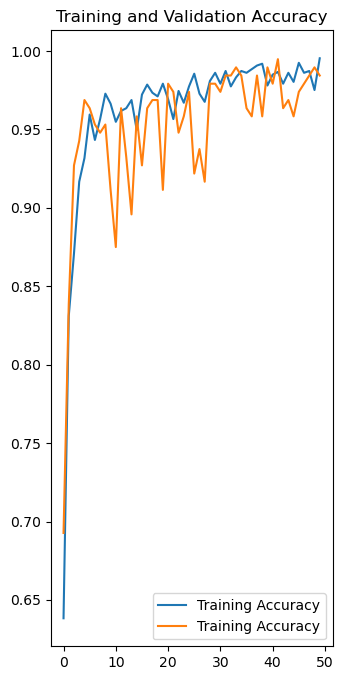

In [96]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
predicted label: Potato___Late_blight


2024-11-19 16:16:10.411932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


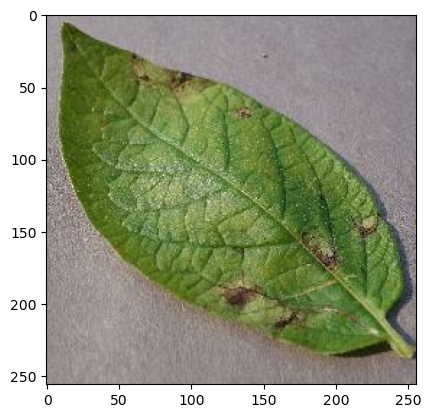

In [100]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    

In [114]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-11-19 16:17:07.991619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


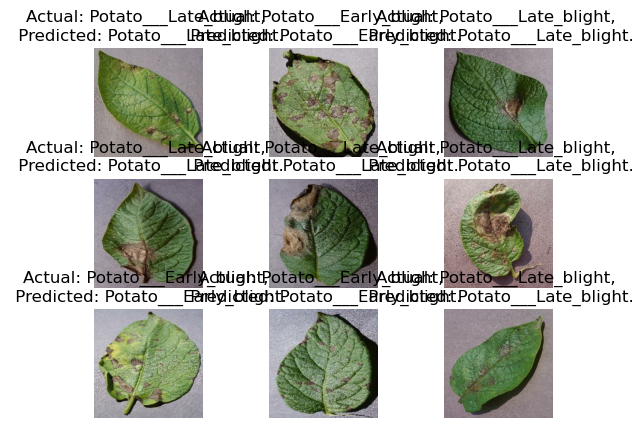

In [116]:
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.")
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [119]:
model_version= 1
model.save(f"../models/{model_version}")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=../models/1.